# Krista, working on linking CO and KO
#from HA species...2/10/2016 

In [2]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
from sklearn.cluster import KMeans
# import palettable as pal

from itertools import chain
import os
import os.path #? not sure if I need both
import glob
import numpy as np
from IPython.core.debugger import Tracer #used this to step into the function and debug it, also need line with Tracer()() 

import matplotlib.pyplot as plt
import matplotlib as mpl #KL moved this here 2/12/2016
#BUT...then messes with the plotting
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline
from collections import Counter
import cPickle as cpk

from stackedBarGraph import StackedBarGrapher
SBG = StackedBarGrapher()



Also, will need to export the following from MATLAB
(1) RInumber, (2) CO number, (3) ion mode information

The KEGG CO numbers from the RI data are not unique. In MATLAB, I have created a new value 'RInumber' which is an arbitrary number for each 'mzRT' feature. The data exported out of MATLAB include that number, the corresponding KEGG CO number, and whether the feature was observed in positive or negative ion mode. These data will be uesd to create a lookup table which allow use of the CO numbers or RInumbers as needed.

In [3]:
mtabFile = 'RImetabolites_isomers.2015.08.27.csv' #first column is RInumber

In [4]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')
# CO_fromMATLAB=CO_RawData[CO_RawData.sum(axis=1)!=0]
#read in the data from MATLAB and take a quick look
CO_fromMATLAB.head(n=5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5
RInumber,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436


make the list of unique cNumbers here, do the KEGG thing and filter the list before I start splitting up the dataframes into data and metadata...

In [5]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

###Write a couple of functions to swap between CO and RInumbers

In [6]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut

##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

In [7]:
def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

In [8]:
#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value, also uses CO_fromMATLAB as input 

In [9]:
#but had trouble getting a tuple to work as an index.
dayList = ['S1','S2','S3','S4','S5'] #this makes a list (mutable, can be changed)
CO_RawData = CO_fromMATLAB.loc[:,dayList]

In [10]:
CO_RawData.head(5)

,S1,S2,S3,S4,S5
RInumber,,,,,
RI1,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,0.000305,0.000486,0.000613,0.000389,0.000436


In [11]:
#Load PhytoKEGG Annotations
#from Harriet...doesn't work, complaining about header=False 
#AllPhytoKO_ann=pd.read_table('AllPhytoKegg_annotated.tab', header=False, delimiter='\t')
# Z:\KLtemp\TranscriptomicsData_Feb2016
#try this instead (note double \\ at end)
pathToData = 'Z:\KLtemp\TranscriptomicsData_Feb2016\\'
AllPhytoKO_ann=pd.read_table((pathToData + 'AllPhytoKegg_annotated.tab'), delimiter='\t')

In [12]:
InsituCounts=pd.read_table((pathToData + 'AllInsitu_NoZero.tab'), index_col='gID')

In [13]:
#normalize to the library size
InsituTPM=InsituCounts.copy()
InsituTPM[['S1', 'S2', 'S3', 'S4', 'S5']]=(InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']]/InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']].sum())*10**6

#Add annotation information
InsituCounts=InsituCounts.join(AllPhytoKO_ann)
InsituTPM=InsituTPM.join(AllPhytoKO_ann)
InsituCounts=InsituCounts.dropna()
InsituTPM=InsituTPM.dropna()

In [14]:
KO_RawData=InsituTPM.groupby('kID').sum()

In [15]:
KO_RawData.head(5)

,S1,S2,S3,S4,S5
kID,,,,,
K00001,3.418232,4.263402,4.675860,5.484786,7.124730
K00002,3.530673,3.253258,3.624972,3.035270,3.707540
K00003,29.043725,19.578968,12.091113,5.617912,8.062782
K00004,0.449767,0.594202,0.791118,0.639004,0.714706
K00005,0.157419,0.163406,0.307001,0.319502,0.469026


In [16]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out

def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

In [17]:
#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code

In [18]:
#use _finalOption variable names to make life easier
KO_finalOption = KO_Norm2Mean.dropna()
CO_finalOption = CO_Norm2Mean.dropna() #already 'limited' this before the normalization

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#this next line prints up some sort of pre-canned details about the program. 
print(__doc__) 

def kmeanCluster(data,nc):
    #kmeans=KMeans(n_clusters=nc)
    kmeans = KMeans(n_clusters = nc, max_iter = 1000, n_init = 50, init = 'random')
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Automatically created module for IPython interactive environment


In [20]:
##First, combine the CO and the KO data
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_final=KO_finalOption.append(CO_finalOption.loc[:,(dayList)])

#go back to Kmeans and finding the right group

In [21]:
filename = 'nClustersRequired.py'
%run $filename

In [22]:
#cheat for the moment...save the data for the data I have as a CSV file and then read it in.
#figure out the format later.
dataFilename = 'NB_unconnected_combined_for_kmeans.csv'
Combined_KO_CO_final.to_csv(dataFilename)

data = Data(dataFilename)
#pattern_labels are the rows...for us this will the RInumber
pattern_labels = []
patterns_data, pattern_labels = data.load_data()

In [23]:
def forest_run(dimensions, patterns, pattern_labels, metric='qe', fNamePrefix = '', k_up=20, k_down=2, simulations=55, iterations=50):
    """
    A method for watching Forest Gump run
    :param dimensions: the dimensionality of the data
    :param patterns: the data itself
    :param metric: the quality metric
    :fNamePrefix: put text in here if I want to add a unique prefix to the data file spit out at end
    :param k_up: the maximum number of clusters
    :param k_down: the minimum number of clusters
    :param simulations: the number of simulations for each k
    :param iterations: the number of iterations for each k-means pass
    """
    # variable to store the best result
    best_clustering = None
    # the quality of that result
    best_quality = 1000.00
    # write results out to file while simulating
    file_out = fNamePrefix + 'MonteCarloFinalResults' + '_' + metric + '.csv'
    #with open(file_out, 'w', newline='') as f: #newline doesn't work here
    with open(file_out,'w') as f:
        # different k values to test on
        for i in range(k_down, k_up):
            num_clusters = i
            # number of retries / simulations
            print('working on ' , i, '# of kmeans groups') #works, but doesn't look as I intended.
            
            for j in range(simulations):
                # create a clustering solution and apply k-means
                clustering = Clustering(dimensions, num_clusters, patterns, 0.0001)
                clustering.k_means_clustering(iterations)
                # used to compute quality of the solution
                quality = ClusteringQuality(clustering, 0.0001)
                this_quality = 0.0
                if metric == 'qe':
                    this_quality = quality.quantization_error()
                if metric == 'si':
                    this_quality = quality.average_silhouette_index()
                if metric == 'db':
                    this_quality = quality.davies_bouldin()
                # update the best clustering
                if this_quality < best_quality:
                    best_quality = this_quality
                    best_clustering = clustering
                    #print("Updated best clustering") #comment out, clogging up display
                # write result to the file
                result = [num_clusters, this_quality]
                for x in result:
                    f.write(str(x))
                    f.write(",")
                f.write("\n")
                f.flush()
                #print(j, result) #comment out, clogging up display
                
        # print the actual clustering out to console...comment this out, too much information
        #best_clustering.print_solution(pattern_labels)

In [24]:
dimensions = 5 #this is a function of the data itself. In the NB data we have five sampling days.
setSimulations = 100
setIterations = 100 #this is the default from the Turing Finance code
setKup = 20
setKdown = 2

In [25]:
#for now, set if to False for the forest_run in the next three cells...that is time consuming

In [26]:
prefix = 'unconnected_norm2mean_'

if False:   
    forest_run(dimensions, patterns_data, pattern_labels, metric='db', fNamePrefix = prefix,
           simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

#read in the results
riScores_db=pd.read_csv((prefix + 'MonteCarloFinalResults_db.csv'),header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

#optimal cluster solution has the smallest Davies-Bouldin index

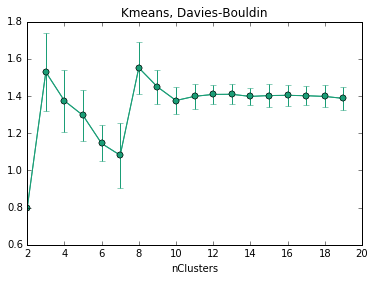

In [27]:
grouped = riScores_db.groupby('nClusters')
means = grouped.mean().unstack()
errors = grouped.std().unstack()
fig, ax = plt.subplots()
plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
plt.title('Kmeans, Davies-Bouldin')
ax.set_xlabel('nClusters')
plt.show() #??? why is now showing all plots?

In [28]:
plt.gcf().canvas.get_supported_filetypes()

{u'eps': u'Encapsulated Postscript',
 u'jpeg': u'Joint Photographic Experts Group',
 u'jpg': u'Joint Photographic Experts Group',
 u'pdf': u'Portable Document Format',
 u'pgf': u'PGF code for LaTeX',
 u'png': u'Portable Network Graphics',
 u'ps': u'Postscript',
 u'raw': u'Raw RGBA bitmap',
 u'rgba': u'Raw RGBA bitmap',
 u'svg': u'Scalable Vector Graphics',
 u'svgz': u'Scalable Vector Graphics',
 u'tif': u'Tagged Image File Format',
 u'tiff': u'Tagged Image File Format'}

In [29]:
# #need this to make a file where the text is actually editable (as oppossed to outlines)
# #import matplotlib as mpl #KL moved to first cell 2/12/2016
fig.savefig('DaviesBouldin_allGenesAndCpds.pdf')

In [30]:
if False:
    prefix = 'unconnected_norm2mean_'

    if False:
        forest_run(dimensions, patterns_data, pattern_labels, metric='qe', fNamePrefix = prefix,
               simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

    #now read in the results
    riScores_qe=pd.read_csv((prefix + 'MonteCarloFinalResults_qe.csv'),header=None,delimiter=',',
                    index_col=False,names=['nClusters', 'score'])

    #goal is to minimize quantization error. QE is the distance between a sample
    #and its representation. Lower quantization errors represent a good data cluster.
    grouped = riScores_qe.groupby('nClusters')
    means = grouped.mean().unstack()
    errors = grouped.std().unstack()
    fig, ax = plt.subplots()
    plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
    plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
    plt.title('Kmeans, Quantization error')
    ax.set_xlabel('nClusters')
    plt.show()

In [31]:
if False: ##silhouette is really slow cfd to the other
    prefix = 'newKO_norm2mean_'

    # #silhouette is quite slow cfd to the other two metrics
    if False:
        forest_run(dimensions, patterns_data, pattern_labels, metric='si', fNamePrefix = prefix,
               simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

    riScores_si=pd.read_csv((prefix + 'MonteCarloFinalResults_si.csv'),header=None,delimiter=',',
                    index_col=False,names=['nClusters', 'score'])


    ##note, want to maximize the silhouette value for each pattern in the dataset
    grouped = riScores_si.groupby('nClusters')
    means = grouped.mean().unstack()
    errors = grouped.std().unstack()
    fig, ax = plt.subplots()
    plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
    plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
    plt.title('Kmeans, silhouette index')
    ax.set_xlabel('nClusters')
    plt.show()

    #remember, want to maximize this value

#Move forward with 'best' number of clusters

In [106]:
#setting # of clusters manually, also some good options with lower # of clusters I think
#this number will get used later when plotting up the BRITE categories and the Kmeans clusters
# makeNclusters = 7  #optimal based on Davies-Bouldin
makeNclusters = 6 #allows direct comparison to connected data

In [107]:
#do the K-means clustering with the final # of clusters
CcoClust=kmeanCluster(Combined_KO_CO_final, makeNclusters) #was 18 

#this will result in a data frame with the kmeans cluster as an added column. Remember
#this will have RI numbers for the compounds

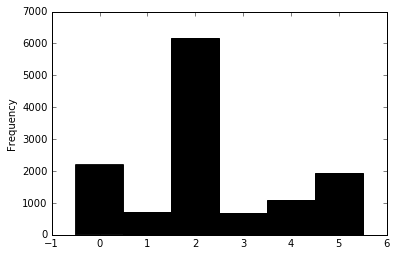

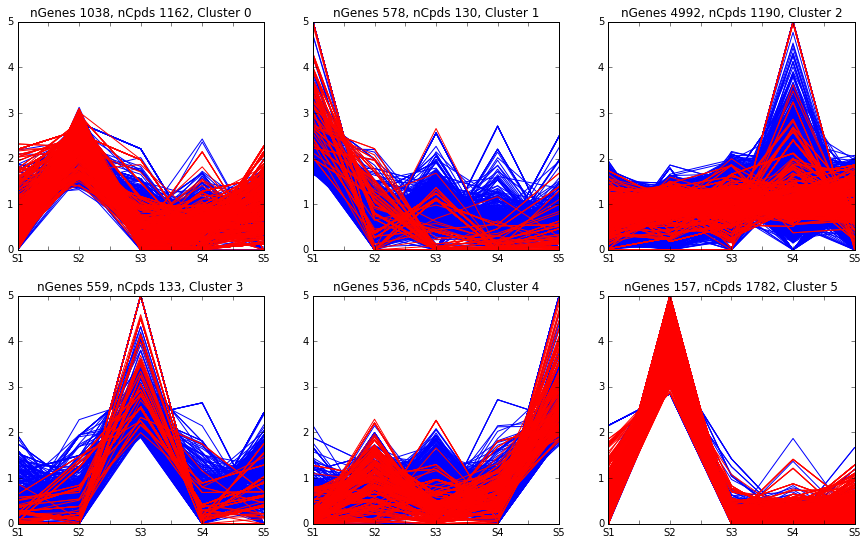

In [110]:
#import matplotlib as mpl
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k',range = (0,kSize),align = 'left')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='b')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='r')
        SumKC=len(KData.T)+len(CData.T)
        KPct=(len(KData.T))
        CPct=(len(CData.T))
        ax.set_title('nGenes ' + str(KPct) + ', nCpds ' + str(CPct) + ', Cluster ' + str(y))
        ax.set_ylim([0,5])
    mpl.rcParams['pdf.fonttype'] = 42
#     fig.savefig('CombinedKOandCO_Kmeans_allGenesAndCpds.pdf')
    fig.savefig('CombinedKOandCO_Kmeans_allGenesAndCpds.png')

PlotKmeansCombined(CcoClust,makeNclusters,2,3, 'r') 

pick up here to change to using biopython module to get maps with merged KO and CO data within a K means group
12 November 2015

In [112]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML

# import random #seems like I can probably skip this, but just comment out in case that is not true

# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# A bit of helper code to shorten long text
def head(text, lines=10):
    """ Print the first lines lines of the passed text.
    """
    print '\n'.join(text.split('\n')[:lines] + ['[...]'])

In [113]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [114]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [115]:
allPathways = kegg_list("pathway").read()
len(allPathways.split('\n'))

486

In [116]:
#so, 481 pathways at KEGG, not all of which are likely to be interesting.
#up to 483 on 12/16/2015

In [117]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
#     Tracer()()
    tp = line[8:13]
    
    trimPath.append('ko' + tp)

In [118]:
#have some cases where KEGG will send back a pathway, but the pathway itself is not searchable...seems to 
#be a KEGG bug, 'ko00351' was first, then realized there are many of these,
#did this list manually since I thought it would be short...
toDelete = ('ko00351','ko01010','ko01060', 'ko01061',  'ko01062', 'ko01063', 'ko01064', 'ko01065', 'ko01066',
 'ko01070', 'ko07011', 'ko07012', 'ko07013', 'ko07014', 'ko07015', 'ko07016', 'ko07017', 'ko07018', 'ko07019',
 'ko07020', 'ko07021', 'ko07023', 'ko07024', 'ko07025', 'ko07026', 'ko07027', 'ko07028', 'ko07029', 'ko07030',
 'ko07031', 'ko07032', 'ko07033', 'ko07034', 'ko07035', 'ko07036', 'ko07037', 'ko07038', 'ko07039', 'ko07040',
 'ko07041', 'ko07042', 'ko07043', 'ko07044', 'ko07045', 'ko07046', 'ko07047', 'ko07048', 'ko07049', 'ko07050',
 'ko07051', 'ko07052', 'ko07053', 'ko07054', 'ko07055', 'ko07056', 'ko07057', 'ko07110', 'ko07112', 'ko07114',
 'ko07117', 'ko07211', 'ko07212', 'ko07213', 'ko07214', 'ko07215', 'ko07216', 'ko07217', 'ko07218', 'ko07219',
 'ko07220', 'ko07221', 'ko07222', 'ko07223', 'ko07224', 'ko07225', 'ko07226', 'ko07227', 'ko07228', 'ko07229',
 'ko07230', 'ko07231', 'ko07232', 'ko07233', 'ko07234', 'ko07235','ko04933')

#probably a way to do this without the for loop, but this will work
for item in toDelete:
    trimPath.remove(item)

In [119]:
colLabel = ['nCpds','nGenes'] #starting with this is easiest - makes one list, no need to flatten

for item in range(makeNclusters):
    colLabel.append('Km' + str(item) + '_cpd')
    colLabel.append('Km' + str(item) + '_gene')
    
gatherCounts = pd.DataFrame(0, index = trimPath, columns = colLabel)

In [120]:
shortList = ['ko03010','ko03013']

In [121]:
#need to change this next bit to NOT require things to be related...this is going to take forever to run...

In [122]:
#But...for the CheckRelatedness...do need to go back to the cNumber...
#for now, easiest to just make yet another matrix and put the cNumbers back in.
notRelated = CcoClust.copy(deep=True) #make a copy of the CcoClust data frame
notRelated.insert(0,'KEGG',"") #add a column called 'KEGG'

for idx in range(0,len(notRelated)):
    t = notRelated.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        notRelated.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        notRelated.ix[idx,('KEGG')] = t
        
notRelated.tail(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
RI4933,C08252,0.272679,2.745732,0.411982,0.538033,1.031575,0
RI4934,C06782,0.781078,3.791043,0.000000,0.000000,0.427880,5
RI4935,C12219,0.063244,4.936756,0.000000,0.000000,0.000000,5
RI4936,C08976,0.000000,4.068887,0.554701,0.138484,0.237929,5
RI4937,C16296,0.341598,3.657856,0.338609,0.295842,0.366096,5


In [123]:
#this set of looks works on one pathway at a time, only plotting if I get more than one case with a reaction
#containing both a gene and a metabolite within the pathway of interest
if True: #can be time consuming (off for editing).
    
    #setup the strings to match first
    rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
    cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

    size = 20 #turns out I can increase the size of the compounds in the plots

    for kn in range(makeNclusters):
#         print kn
    #for kn in range(5,6): 
    #for kn in range(0):    

        fullSet = set(notRelated.KEGG)
        oneK = notRelated[notRelated.kmeans == kn] #get gene & transcript information for one Kmeans group
        getKm = 'Km' + str(kn)

#         #check if the directories exist 
#         directoryPDF = 'plots_6Kmeans_unconnected' + str(kn) + '/PDFfiles'
#         if not os.path.exists(directoryPDF):
#             os.makedirs(directoryPDF)

#         #check if the directories exist 
#         directoryPNG = 'plots_6Kmeans_unconnected' + str(kn) + '/PNGfiles'
#         if not os.path.exists(directoryPNG):
#             os.makedirs(directoryPNG)    
        
        for item in trimPath: #searching within one pathway at a time
        #for item in shortList: #short list for testing
            #print kn, item
            plotPathway = [] #gather up yes/no and will only plot if have linked genes/mtabs
        
            genes = getKfrom_ko(item)
            compounds = getCfrom_ko(item)

            gatherCounts.loc[item,'nCpds'] = len(compounds)
            gatherCounts.loc[item,'nGenes'] = len(genes)     

            #have to track genes and compounds differently for the biopython plotting later on 
            setG = set(genes)
            setC = set(compounds)
            setB = set(oneK.KEGG)
            intGenes = setG.intersection(setB)
            intCompounds = setC.intersection(setB)

            gatherCounts.loc[item,(getKm + '_gene')] = len(intGenes)
            gatherCounts.loc[item,(getKm + '_cpd')] = len(intCompounds)

 

In [124]:
#want to export gatherCounts, with the added pathway name as a new column
gatherCounts['pathwayInfo'] = ''
gatherCounts['pathwayGroup_A'] = ''
gatherCounts['pathwayGroup_B'] = ''
gatherCounts['pathwayGroup_C'] = ''

In [125]:
type(gatherCounts)

pandas.core.frame.DataFrame

In [126]:
#still the same size, just more values in each cell in the data frame
gatherCounts.shape

(399, 18)

In [127]:
#organize pathways into the groups defined in the BRITE file (didn't work well for compounds, 
#but the pathway groups seem useful)
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

        return forBrite

In [128]:
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 12/15/2015
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof) 
    
allBRITE.loc[allBRITE['map']=='01100']

,map,A,B,C,wholeThing
10,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n


In [129]:
#KEGG seems to be updating pathways...finding some where gatherCounts has a pathway, 
#but it is missing from the BRITE file
#ko04139, added to KEGG 12/1/15, pathway is: 'regulation of mitophagy' 
#ko04211, added to KEGG 12/14/15, pathway is 'longevity regulating pathway mammal
#let's delete it from gatherCounts

gatherCounts = gatherCounts.drop(['ko04139'])
gatherCounts = gatherCounts.drop(['ko04211'])
gatherCounts = gatherCounts.drop(['ko04212']) #longevity regularing pathway - worm


#note that this cell will only work once

In [130]:
gatherCounts = gatherCounts.drop(['ko04213'])

In [131]:
#put the pathway name and group into the data frame before exporting it
for item in gatherCounts.index:
    #if this error appears: IndexError: index 0 is out of bounds for axis 0 with size 0
    #KEGG has updated a pathway, but not the BRITE file (see above...) have to delete that 
    #row from GatherCounts; run again with the next row uncommented out to find the culprit.
    #print item
    
    pathstr = kegg_list(item).read()
    #this next line splits the string at the '\t', then keeps the piece at index = 1, and strips off the '\n'
    gatherCounts.loc[item,('pathwayInfo')] = pathstr.split('\t')[1].rstrip()
    
    t = allBRITE.loc[allBRITE['map']==item[2:]]  

    gatherCounts.set_value(item,'pathwayGroup_A',t['A'].values[0])
    gatherCounts.set_value(item,'pathwayGroup_B',t['B'].values[0])
    gatherCounts.set_value(item,'pathwayGroup_C',t['C'].values[0])
    
    del t

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
if False:
    #now export the result as CSV file
    gatherCounts.to_csv('pathways_with_Kmeans_KOnorm2Mean.2016.02.16.csv', header = True)

In [ ]:
#now...save all that so I don't have to do this everytime BUT be careful with re-assigning K means group numbers!
cpk.dump(gatherCounts, open('gatherCounts_unconnected_norm2mean.2016.03.31.pickle', 'wb'))
gatherCounts = cpk.load(open('gatherCounts_unconnected_norm2mean.2016.03.31.pickle','rb'))
gatherCounts.head(2)

In [ ]:
newCols = colLabel[2:] #this is actually all the columns (used in plotting)
newCols

In [ ]:
cpdCols = colLabel[2::2]
cpdCols 

In [ ]:
geneCols = colLabel[3::2]
geneCols

In [ ]:
#pluck code from Harriet, trim down a bit, need a few pieces
import palettable.colorbrewer as b2m
from matplotlib.colors import LogNorm, NoNorm, BoundaryNorm

In [ ]:
def HeatMap(heatmapData, columns=None,colormap=b2m.sequential.GnBu_9.get_mpl_colormap(), m=1e-5):
    #note - m in the above function is a small, but non-zero number, allows the LogNorm function to work
    #clean up the data to make a pretty heatmap
    heatmapData['mean']=heatmapData.mean(skipna = 1, axis=1) #calculate mean value for each class
    heatmapData=heatmapData.sort_values(by='mean', ascending=False)#Sort by the mean value
    heatmapData=heatmapData.drop('mean',1) #drop mean column
    heatmapData=heatmapData.loc[heatmapData.sum(axis=1)!=0]

    col_labels=list(heatmapData.index)
    row_labels=list(heatmapData.columns.values)
    fig3,ax3=plt.subplots()
    fig3.set_figheight(len(col_labels)/2)
    fig3.set_figwidth(len(row_labels)*2)
    
    #this works, but I haven't quite figured out the best values for the colors (though I like the green/blue)
    bounds = np.linspace(heatmapData.min().min() ,heatmapData.max().max())
    heatmap3 = ax3.pcolor(heatmapData, cmap=colormap, norm=BoundaryNorm(boundaries = bounds,ncolors=1000))
       
    ax3.set_xticks(np.arange(heatmapData.shape[1])+0.5, minor=False)
    ax3.set_yticks(np.arange(heatmapData.shape[0])+0.5, minor=False)
    ax3.invert_yaxis()
    ax3.xaxis.tick_top()
    ax3.margins(0,0)

    ax3.set_xticklabels(row_labels, minor=False)
    ax3.set_yticklabels(col_labels, minor=False)
    plt.colorbar(heatmap3)
    plt.show()
    return fig3


#Testing=HeatMap(data)
#Testing.savefig('testing.png', bbox_inches = 'tight')

#Testing.savefig('Insitu_KEGG_Heatmap.pdf')

In [ ]:
##let's narrow in on the metabolism group since that is the only one that is really interesting
plotMetabolism = gatherCounts[gatherCounts.loc[:,'pathwayGroup_A']=='Metabolism']

s = plotMetabolism[(plotMetabolism.loc[:,newCols].values > 0).any(axis=1)]
dataToPlot = s.loc[:,newCols]

pGroup = pd.unique(plotMetabolism.pathwayGroup_B.ravel())

newDFmtab = pd.DataFrame(index = pGroup,columns = newCols)

for i, group in s.groupby('pathwayGroup_B'): #pathwayGroup_C is the most detailed rendition
    d2 = group.loc[:,newCols]
    out = d2.sum(axis=0)
    newDFmtab.loc[i,newCols] = out
    
#this next line is the part that selects compounds or genes    
# toPlot_heatmap = newDFmtab.loc[:,cpdCols]
toPlot_heatmap = newDFmtab.loc[:,geneCols]


# The global and overview maps will be empty, so get rid of it
toPlot_heatmap = toPlot_heatmap.drop(['Global and overview maps'])

figOut = HeatMap(toPlot_heatmap)
figOut.savefig('Heatmap_all.png', bbox_inches = 'tight')

In [ ]:
##let's narrow in on the metabolism group since that is the only one that is really interesting
plotMetabolism = gatherCounts[gatherCounts.loc[:,'pathwayGroup_A']=='Metabolism']

s = plotMetabolism[(plotMetabolism.loc[:,newCols].values > 0).any(axis=1)]
dataToPlot = s.loc[:,newCols]

pGroup = pd.unique(plotMetabolism.pathwayGroup_B.ravel())

newDFmtab = pd.DataFrame(index = pGroup,columns = newCols)

for i, group in s.groupby('pathwayGroup_B'): #pathwayGroup_C is the most detailed rendition
    d2 = group.loc[:,newCols]
    out = d2.sum(axis=0)
    newDFmtab.loc[i,newCols] = out
    
#this next line is the part that selects compounds or genes    
toPlot_heatmap = newDFmtab.loc[:,cpdCols]
# toPlot_heatmap = newDFmtab.loc[:,geneCols]


# The global and overview maps will be empty, so get rid of it
toPlot_heatmap = toPlot_heatmap.drop(['Global and overview maps'])

figOut = HeatMap(toPlot_heatmap)
figOut.savefig('Heatmap_all.png', bbox_inches = 'tight')

In [ ]:
toPlot_heatmap.max()

In [ ]:
#with this rendition of K means, Km0 is the group with no changes...largest number of genes/compounds